In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


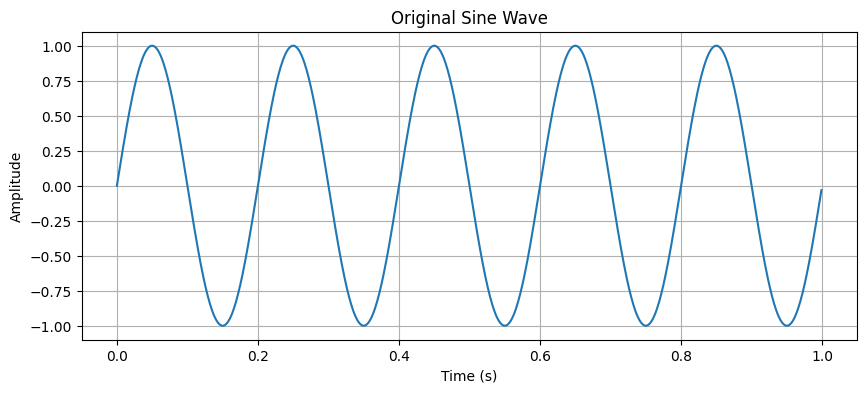

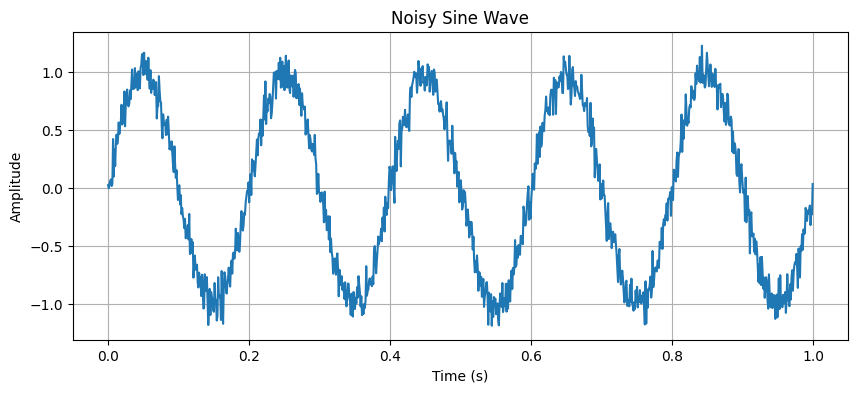

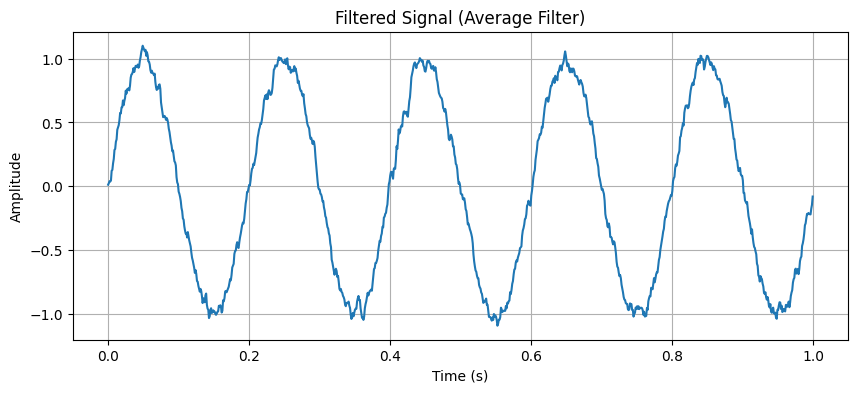

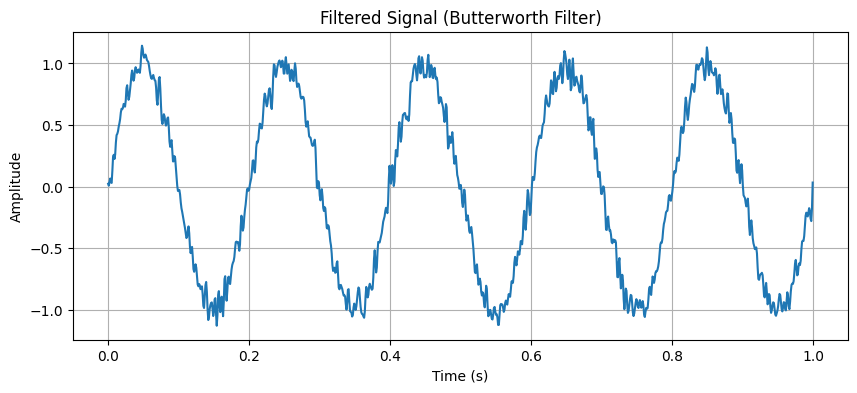

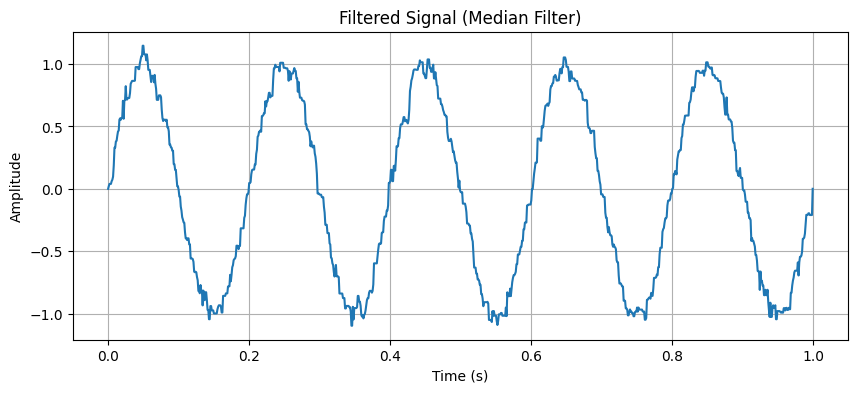

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def generate_signal(signal_type, **kwargs):
    if signal_type == 'sine':
        return generate_sine_wave(**kwargs)
    elif signal_type == 'noisy_sine':
        return generate_noisy_signal(**kwargs)
    else:
        raise ValueError("Invalid signal type. Choose 'sine' or 'noisy_sine'.")

def generate_sine_wave(freq, amplitude, phase, sample_rate, duration):
    t = np.arange(0, duration, 1/sample_rate)
    wave = amplitude * np.sin(2 * np.pi * freq * t + phase)
    return t, wave

def add_noise(signal, noise_level):
    noise = np.random.normal(0, noise_level, len(signal))
    return signal + noise

def apply_filter(signal, filter_type, **kwargs):
    if filter_type == 'average':
        return apply_average_filter(signal, **kwargs)
    elif filter_type == 'butterworth':
        return apply_butterworth_filter(signal, **kwargs)
    elif filter_type == 'median':
        return apply_median_filter(signal, **kwargs)
    else:
        raise ValueError("Invalid filter type. Choose 'average', 'butterworth', or 'median'.")

def apply_average_filter(signal, window_size):
    filter_kernel = np.ones(window_size) / window_size
    return np.convolve(signal, filter_kernel, mode='same')

def apply_butterworth_filter(signal, order, cutoff):
    b, a = sp.signal.butter(order, cutoff, output='ba')
    return sp.signal.filtfilt(b, a, signal)

def apply_median_filter(signal, kernel_size):
    return sp.signal.medfilt(signal, kernel_size)

def plot_signal(t, signal, title):
    plt.figure(figsize=(10, 4))
    plt.plot(t, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

def main():
    # Example values
    freq = 5  # Frequency of the sine wave (Hz)
    amplitude = 1  # Amplitude of the sine wave
    phase = 0  # Phase of the sine wave (in radians)
    sample_rate = 1000  # Sample rate (samples per second)
    duration = 1  # Duration of the signal (seconds)
    noise_level = 0.1  # Standard deviation of noise

    N = 5  # N for the noisy sine signal
    samples = 500  # Number of samples for the noisy sine signal
    F = 2  # Frequency of the sine wave for the noisy sine signal (Hz)
    LEVEL = 0.1  # Noise level for the noisy sine signal

    window_size = 5  # Window size for average filter
    order = 5  # Order for Butterworth filter
    cutoff = 0.5  # Cutoff frequency for Butterworth filter
    kernel_size = 5  # Kernel size for median filter

    # Generate sine wave
    t, sine_wave = generate_signal('sine', freq=freq, amplitude=amplitude, phase=phase, sample_rate=sample_rate, duration=duration)

    # Add noise to sine wave
    noisy_signal = add_noise(sine_wave, noise_level)

    # Plot original sine wave
    plot_signal(t, sine_wave, 'Original Sine Wave')

    # Plot noisy sine wave
    plot_signal(t, noisy_signal, 'Noisy Sine Wave')

    # Apply filters
    # Average filter
    filtered_average = apply_filter(noisy_signal, 'average', window_size=window_size)
    plot_signal(t, filtered_average, 'Filtered Signal (Average Filter)')

    # Butterworth filter
    filtered_butterworth = apply_filter(noisy_signal, 'butterworth', order=order, cutoff=cutoff)
    plot_signal(t, filtered_butterworth, 'Filtered Signal (Butterworth Filter)')

    # Median filter
    filtered_median = apply_filter(noisy_signal, 'median', kernel_size=kernel_size)
    plot_signal(t, filtered_median, 'Filtered Signal (Median Filter)')

if __name__ == "__main__":
    main()


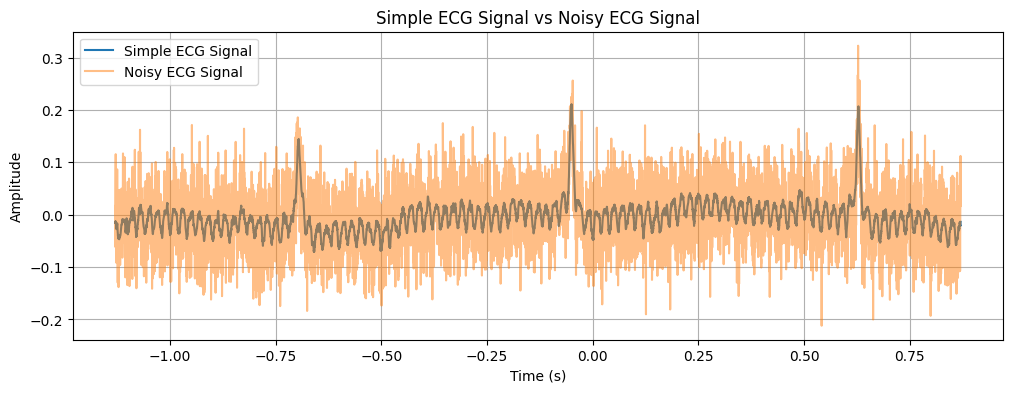

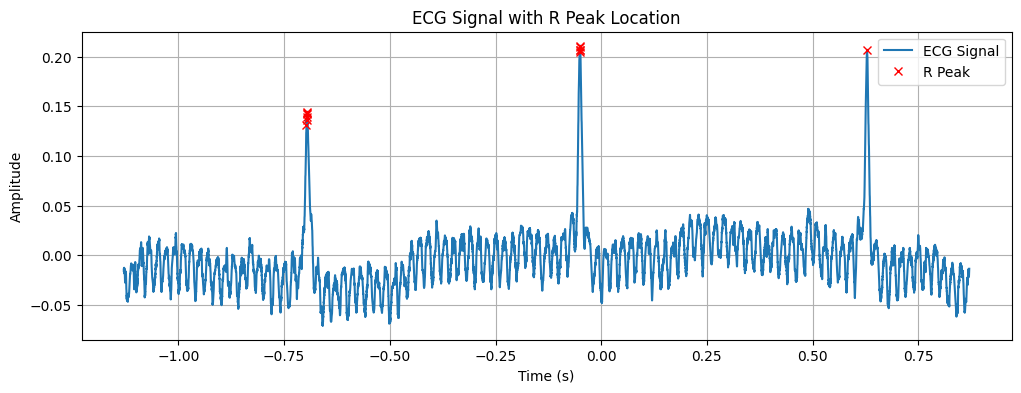

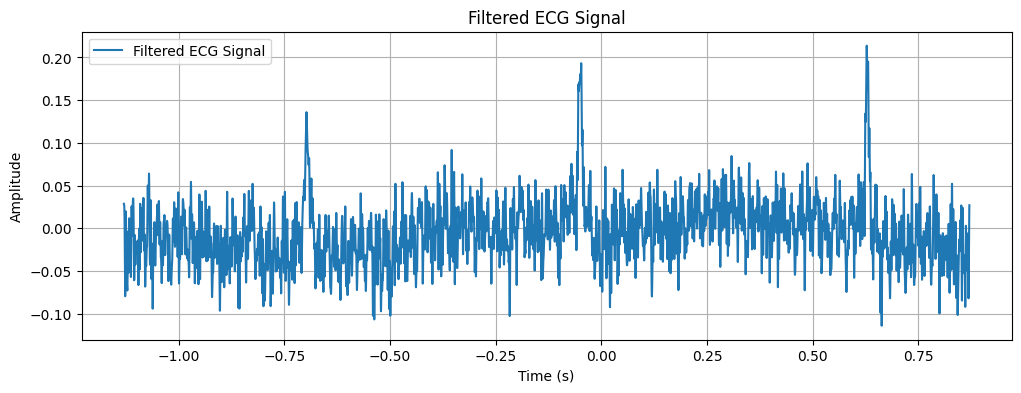

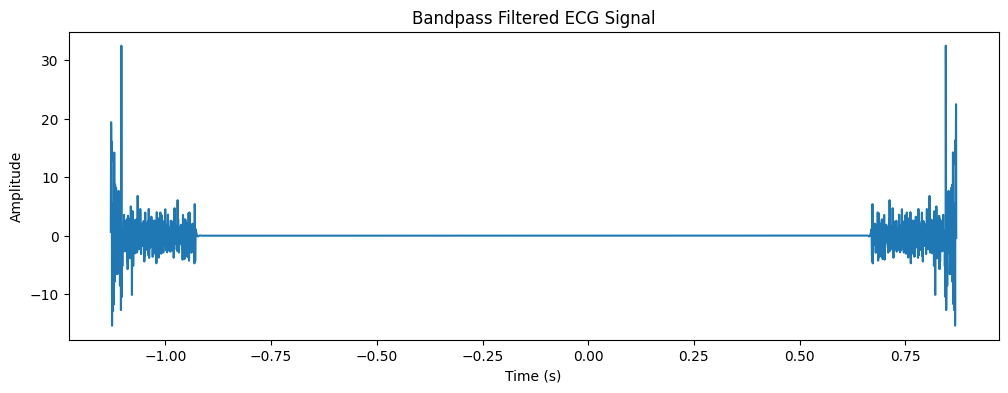

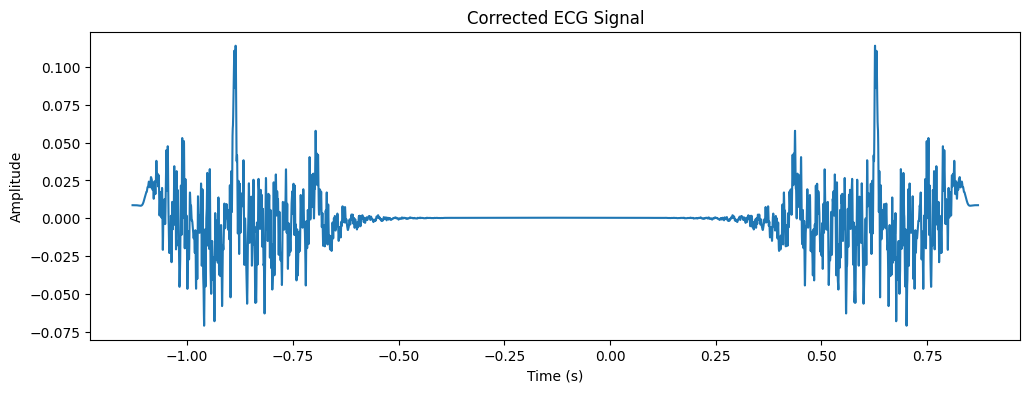

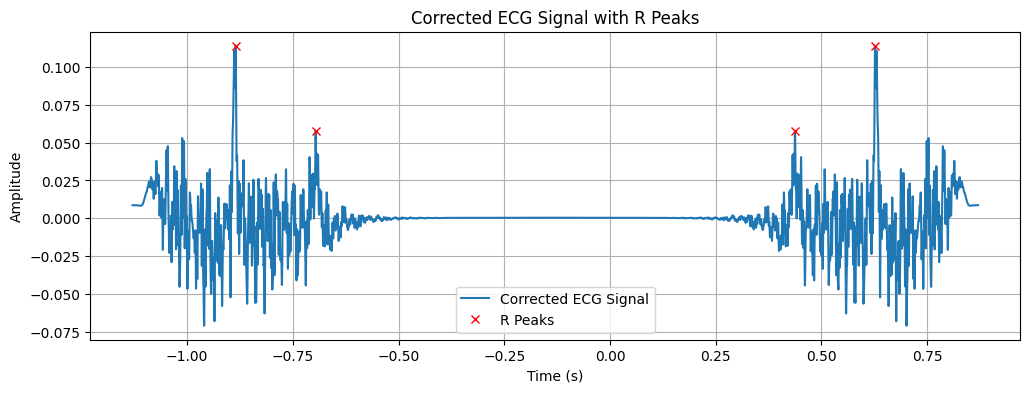

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fft import fft, ifft
import pandas as pd

# Load the ECG signal (replace 'path_to_ecg_file.csv' with the actual file path)
#ecg_table = pd.read_csv("/home/nalin/Downloads/ecg(1).csv")
ecg_table = pd.read_csv("ecg(1).csv")


# Extract amplitude and time
ecg = ecg_table['Channel 1 (V)']
time = ecg_table['Time (s)']

# Add noise to the ECG signal
noise_level = 0.05  # Adjust as needed
noisy_ecg = ecg + np.random.normal(0, noise_level, len(ecg))

# Plot simple ECG signal and noisy ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time, ecg, label='Simple ECG Signal')
plt.plot(time, noisy_ecg, label='Noisy ECG Signal', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Simple ECG Signal vs Noisy ECG Signal')
plt.legend()
plt.grid(True)
plt.show()

# Compute and show the location of the R peak
peaks, _ = find_peaks(ecg, height=0.6 * np.max(ecg))

plt.figure(figsize=(12, 4))
plt.plot(time, ecg, label='ECG Signal')
plt.plot(time[peaks], ecg[peaks], 'x', color='red', label='R Peak')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with R Peak Location')
plt.legend()
plt.grid(True)
plt.show()

# Define a filter in the frequency domain to preserve the R peak
def frequency_domain_filter(signal, peak_indices, cutoff_freq):
    signal = np.asarray(signal)  # Convert to numpy array
    fft_signal = fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    for idx in peak_indices:
        fft_signal[(freqs < -cutoff_freq)] = 0
        fft_signal[(freqs > cutoff_freq)] = 0
    return np.real(ifft(fft_signal))

# Apply the filter to the noisy ECG signal
cutoff_frequency = 0.1  # Adjust as needed
filtered_ecg = frequency_domain_filter(noisy_ecg, peaks, cutoff_frequency)

# Plot the filtered ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time, filtered_ecg, label='Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered ECG Signal')
plt.legend()
plt.grid(True)
plt.show()

# Bandpass filtering
Fs = 360
low_cut = 10
high_cut = 80
Bw = [low_cut / (Fs / 2), high_cut / (Fs / 2)]
b, a = butter(N=3, Wn=Bw, btype='band')
fft_filtered = filtfilt(b, a, fft(filtered_ecg)).real

plt.figure(figsize=(12, 4))
plt.plot(time, fft_filtered)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Bandpass Filtered ECG Signal")
plt.show()

# Base correction
def base_correction(ecg_signal, window_size):
    x = fft(ecg_signal)
    Fc = 5
    F_normal = Fc / (Fs / 2)
    b, a = butter(N=5, Wn=F_normal, btype='high')
    filtered = filtfilt(b, a, x).real
    return ifft(filtered).real

ecg_corrected = base_correction(ecg_signal=ecg_filtered, window_size=5)

plt.figure(figsize=(12, 4))
plt.plot(time, ecg_corrected)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Corrected ECG Signal")
plt.show()

# Find R Peaks with adjusted parameters
prominence_threshold = 0.111111  # Adjust as needed
distance_min = 100  # Adjust as needed
peaks_corrected, _ = find_peaks(x=ecg_corrected, prominence=prominence_threshold, distance=distance_min)

# Plot Corrected ECG Signal with R Peaks
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_corrected, label='Corrected ECG Signal')
plt.plot(time[peaks_corrected], ecg_corrected[peaks_corrected], 'x', color='red', label='R Peaks')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Corrected ECG Signal with R Peaks")
plt.legend()
plt.grid(True)
plt.show()

